In [1]:
!nvidia-smi

Thu Dec 18 05:51:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:B2:00.0 Off |                  N/A |
| 22%   23C    P8             18W /  250W |       1MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
# NOTE!
# this is for a multi-gpu setup. we basically set which GPU is visible for the program.
# if you only have one GPU (most likely the case ;) ), make sure this is set to "0"!
# or remove this line completely!
# otherwise you may accidentally make your GPU "invisible" to the program!
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# NICE Flow

Most ironically named model in this class!

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from lgm.common import count_parameters, plot_learning_curves, sum_except
from lgm.data import get_datasets_and_loaders, dataset_mean_std, Normalize, UniformDequantize
from lgm.evaluation import get_classifier, fid, inception_score_with_features, precision_recall
from lgm.flow import NiceFlow, FlowTrainer

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

## Toy Example

Because flows can take some work to get right, we first try to fit a simple toy example.
As long as this works, you can at least be fairly certain that failure to fit more complex datasets is not due to incorrect implementation, but simply due to issues with the architecture/framework.
Here we use a 2D "banana" dataset, which is created through a direct transformation from Gaussian distributions.
As such, it should definitely be possible to invert this transformation!

Note that we use `StackDataset` and seem to be duplicating the samples; this is because our training interface expects labels in all datasets, but we don't have any.
So we duplicate the data to create fake labels that are never used.

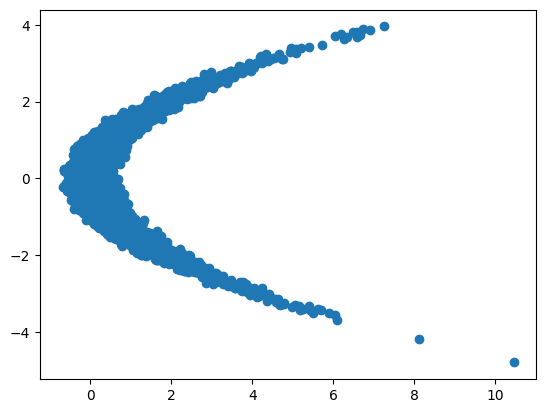

In [4]:
n_samples = 10000
x2_dist = torch.distributions.Normal(loc=0., scale=0.5)
x2_samples = x2_dist.sample((n_samples,))
x1 = torch.distributions.Normal(loc=1. * x2_samples**2, scale=0.1)
x1_samples = x1.sample()
x_samples = torch.stack([x1_samples, x2_samples], dim=1)

# optional: normalize data to overall standard deviation 1.
# the model should work either way!
x_samples = x_samples / torch.std(x_samples)

as_np = x_samples.numpy()
plt.scatter(as_np[:, 0], as_np[:, 1])
plt.show() 

In [5]:
loader = torch.utils.data.DataLoader(torch.utils.data.StackDataset(x_samples, x_samples), batch_size=256, pin_memory=True, num_workers=4)

### Creating the Model

Usual stuff. Since this is just a 2D example, we use small fully-connected layers. The model as given should be enough.

It is very important to check the correctness of your model. The forward and backward transforms **must be** inverses of each other.
We test this by applying both directions in sequence and computing the difference to the original.
If this is meaningfully different from 0, **do not continue**.
Your implementation is wrong.
It makes **no sense** to try and fit an incorrect Flow model!
Small differences are okay, and can be attributed to numerical imprecision.
For such a small model, you might expect differences on the order of `1e-07` to `1e-06` or so.
For much larger models, the difference can be larger.

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

input_dim = 2
hidden_dim = 32


def layer_factory(in_dim):
    return nn.Sequential(nn.Linear(in_dim, hidden_dim),
                         nn.LayerNorm(hidden_dim),
                         nn.LeakyReLU(),
                         nn.Linear(hidden_dim, in_dim))

    
base_distribution = torch.distributions.Normal(loc=0., scale=1.)
model = NiceFlow((input_dim,), n_layers=4, transform_factory=layer_factory, base_distribution=base_distribution).eval()

simple_samples = base_distribution.sample((n_samples, input_dim))

with torch.no_grad():
    test_generated = model.transform_backward(simple_samples)
    simple_again = model.transform_forward(test_generated)

inversion_difference = (simple_samples - simple_again).numpy()

print('\nIs this near 0? If not, DO NOT CONTINUE! FIX YOUR MODEL :)')
print(inversion_difference.min(), inversion_difference.max())

model = model.to(device)

Using cuda device

Is this near 0? If not, DO NOT CONTINUE! FIX YOUR MODEL :)
-2.3841858e-07 4.7683716e-07


In [8]:
n_epochs = 200

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.0, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer = FlowTrainer(model=model, optimizer=optimizer, scheduler=scheduler,
                     training_loader=loader, validation_loader=loader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=None, verbose=True)

In [ ]:
metrics = trainer.train_model()

We can plot the generated over the real samples. The two distributions should be pretty much the same. You can expect the generations to not capture outliers in the training data very well, i.e. the generated samples may be slightly more "compact".

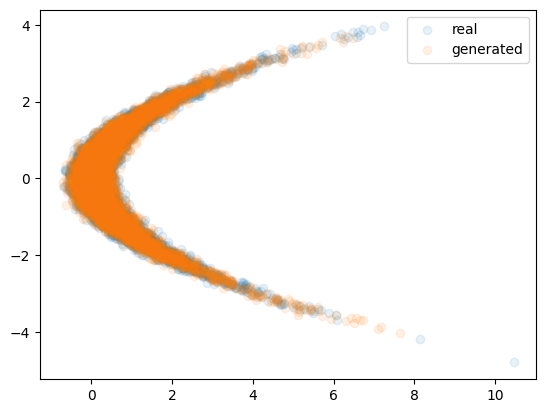

In [10]:
with torch.inference_mode():
    toy_generated = model.generate(10000)

as_np_generated = toy_generated.detach().cpu().numpy()
plt.scatter(as_np[:, 0], as_np[:, 1], alpha=0.1, label="real")
plt.scatter(as_np_generated[:, 0], as_np_generated[:, 1], alpha=0.1, label="generated")
plt.legend()
plt.show() 

## Real Data

Consider this somewhat optional. You will likely not get great results using this model. But it never hurts to at least try it out.
We employ desparate measures and go to the real, actual MNIST. Not even FashionMNIST.
We can optionally normalize the data to mean 0 and standard deviation 1.
This can help the model find the "correct" scaling.
Simply uncomment the line with the `dataset_mean_std` function and remove the one below.

**Note**, your loss will likely get worse (higher) when you use the normalized data.
This is simply because this will lift the data to a wider scale (since we divide by a standard deviation less than 1), which forces the "probability mass" to expand over a larger volume, in turn leaving lower densitys per sample.
This does not mean that the model is worse.
It's possible to account for this in the loss, but we elected not to do this for now.

In any case, we also have to "dequantize" the data, because we are strictly speaking modeling discrete data -- images are usually stored as 8bit integers, allowing only for 256 unique values per pixel -- with a continuous model.
The accepted fix is to add noise of up to 1 pixel value to fill in the gaps.

The code here is somewhat hacky. We first get dataloaders, and then only use those to compute means and standard deviations.
Then we get a _new_ dataloader where we also pass the `Normalize` transform.
This could be streamlined somewhat. :)

In [11]:
data = "mnist"
batch_size = 256

train_data, test_data, train_dataloader, test_dataloader = get_datasets_and_loaders(data, batch_size, num_workers=16, verbose=False)

#data_mean, data_std = dataset_mean_std(train_dataloader, per_dim=False)
data_mean, data_std = torch.tensor(0.), torch.tensor(1.)
data_mean, data_std

(tensor(0.), tensor(1.))

Shape/dtype of batch X [N, C, H, W]: torch.Size([256, 1, 32, 32]), torch.float32
Shape/dtype of batch y: torch.Size([256]), torch.int64


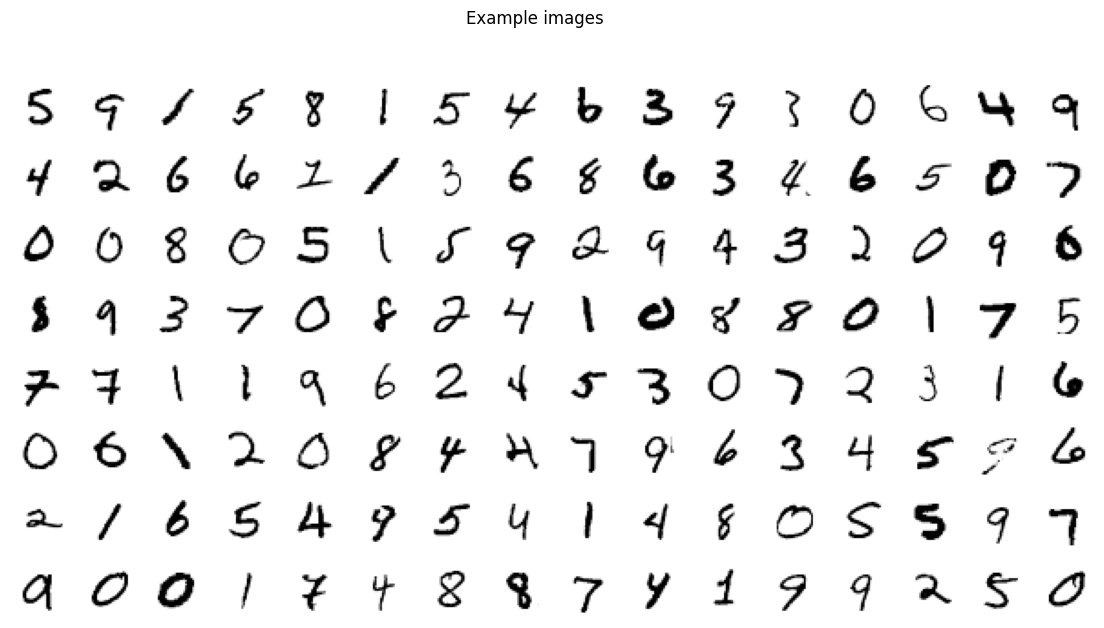

In [12]:
def descale_data(imgs):
    return data_std.to(imgs.device) * imgs + data_mean.to(imgs.device)


scale_data = Normalize(data_mean, data_std)

train_data, test_data, train_dataloader, test_dataloader = get_datasets_and_loaders(data, batch_size, num_workers=16,
                                                                                    additional_transforms=[UniformDequantize(), scale_data],
                                                                                    plot_descale=descale_data)

### Model

NICE is not equipped to handle convolutions, so we use MLPs for the coupling layers. Flows in general seem to be not very parameter efficient, and this is made worse by using MLPs.
These networks are rather large for MNIST compared to other types of models.

You can also experiment with the `scale_fn`. This function transforms arbitrary real numbers (the parameter in `model.scaler`) to positive numbers.
Each dimension is multiplied by the respective scale at the end of the forward transformation.
Behavior will likely change drastically depending on the `scale_fn`.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

hidden_dim = 1024
n_groups = 32  # for GroupNorm
n_coupling_layers = 16


def layer_factory(in_dim):
    return nn.Sequential(nn.Linear(in_dim, hidden_dim),
                         nn.GroupNorm(n_groups, hidden_dim),
                         nn.Mish(),
                         
                         nn.Linear(hidden_dim, hidden_dim),
                         nn.GroupNorm(n_groups, hidden_dim),
                         nn.Mish(),

                         nn.Linear(hidden_dim, hidden_dim),
                         nn.GroupNorm(n_groups, hidden_dim),
                         nn.Mish(),

                         nn.Linear(hidden_dim, hidden_dim),
                         nn.GroupNorm(n_groups, hidden_dim),
                         nn.Mish(),
                    
                         nn.Linear(hidden_dim, in_dim))


with torch.no_grad():
    dummy = next(iter(train_dataloader))[0].to(device)
data_shape = dummy.shape[1:]


base_distribution = torch.distributions.Normal(loc=0., scale=1.)
scale_fn = torch.exp
model = NiceFlow(data_shape, n_layers=n_coupling_layers, transform_factory=layer_factory, base_distribution=base_distribution, scale_fn=scale_fn).eval()

simple_samples = base_distribution.sample((batch_size, model.total_dim))

with torch.no_grad():
    test_generated = model.transform_backward(simple_samples)
    simple_again = model.transform_forward(test_generated)

inversion_difference = (simple_samples - simple_again).numpy()

print('\nIs this near 0? If not, DO NOT CONTINUE! FIX YOUR MODEL :)')
print(inversion_difference.min(), inversion_difference.max())

model = model.to(device)
model.compile()

Using cuda device

Is this near 0? If not, DO NOT CONTINUE! FIX YOUR MODEL :)
-6.377697e-06 5.722046e-06


In [14]:
num_params = count_parameters(model)
print(f"Model with {num_params:,d} trainable parameters")

Model with 67,314,688 trainable parameters


### Training

The optimizer is a point of contention. The paper claims somewhat non-standard parameters for the Adam optimizer, such as $\beta_2 = 0.01$, whereas the default is $0.999$. It is unclear whether this is a typo and they actually mean $\beta_2 = 0.99$. They also say they use $\lambda = 1$, but Adam does not have a parameter called $\lambda$... BTW, they also claim training for 1500 epochs.

Note that it may be worth removing weight decay from `AdamW`, as it seems to disproportionally affect the scaling parameter. Also, we got somewhat more "regular" (albeit not really better) results using `SGD` (commented out line) instead of Adam.

In [15]:
n_epochs = 350

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer = FlowTrainer(model=model, optimizer=optimizer, scheduler=scheduler,
                      training_loader=train_dataloader, validation_loader=test_dataloader,
                      n_epochs=n_epochs, device=device, plot_every_n_epochs=20, verbose=True,
                      plot_descale=descale_data,
                      use_bits_per_dim=True,)

In [ ]:
metrics = trainer.train_model()

In [29]:
n_epochs = 350

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

trainer = FlowTrainer(model=model, optimizer=optimizer, scheduler=scheduler,
                      training_loader=train_dataloader, validation_loader=test_dataloader,
                      n_epochs=n_epochs, device=device, plot_every_n_epochs=20, verbose=True,
                      plot_descale=descale_data,
                      use_bits_per_dim=True,)

Note, Flow models tend to take very long to compile for some reason. Don't be alarmed if the first epoch of training is very slow.

In [ ]:
metrics = trainer.train_model()

### Evaluation

All the usual stuff here.

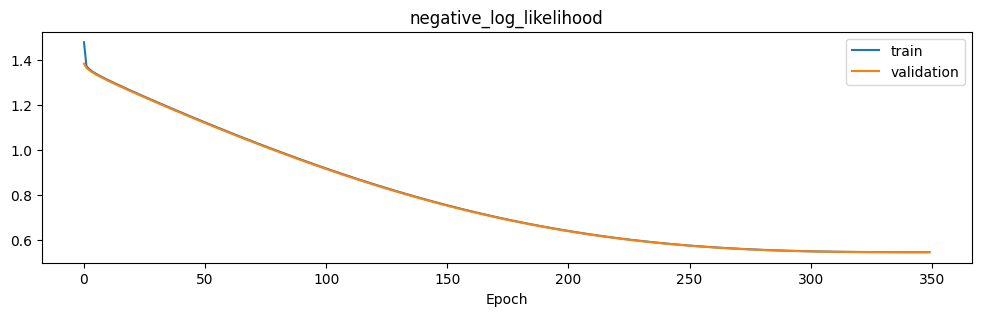

In [31]:
plot_learning_curves(metrics, ["negative_log_likelihood"])

In [33]:
classifier = get_classifier(data, "weights").to(device)

feature_extractor = classifier[:-3]
classifier.eval()
feature_extractor.eval()
head = classifier[-3:]
head.eval()


def generate_wrap(n_samples):
    with torch.inference_mode():
        return torch.clamp(descale_data(model.generate(n_samples)), 0, 1)

_, _, _, test_dataloader_noscale = get_datasets_and_loaders(data, batch_size, num_workers=16, verbose=False)

In [ ]:
fid_score, real_features, generated_features = fid(feature_extractor, test_dataloader_noscale, generate_wrap, n_samples=50000, return_features=True, use_tqdm=True)
print(fid_score)

Computing real features:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
inception_score_with_features(head, generated_features, batch_size)

In [ ]:
precision_recall(real_features, generated_features, batch_size, k=10, use_tqdm=True)

We can also display the per-dimension scaling values as an image. Note that we apply the scaling function.
This gives an idea of how much each "pixel" is scaled.
However, this cannot be interpreted directly with respect to the image pixels, as the variables are transformed by the coupling layers before being scaled.
Still, it can give us some insight -- a common pattern is that a few dimensions are scaled much lower/higher than most tothers, which could indicate some sort of defect in the model.

In [ ]:
scale_np = scale_fn(model.scaler).detach().cpu().numpy()
scale_img = scale_np.reshape(data_shape)[0]
plt.imshow(scale_img, cmap="Greys_r")
plt.colorbar()
plt.title("Per-dimension scaling")
plt.show()

We can also get an overview of the per-dimension scaling with a sorted plot. Note that we look at the inverse.
Since the scaler transforms data to noise, the noise -> data direction is scaled by the inverse.
This is supposed to give some idea of the scale of the various data dimensions... or something.

In [ ]:
plt.plot(sorted(1/scale_np, reverse=True))
plt.xlabel("Dimension (sorted)")
plt.ylabel("Scaling")
plt.show()

Finally, we can get some idea of how well the model has turned the data into the prior distribution.
We can generate some random standard normal values and measure their average euclidean norm (distance from the mean at 0).

In [ ]:
ideal_samples = torch.randn(60000, *data_shape)
ideal_norms = torch.sqrt(sum_except(ideal_samples**2))
plt.hist(ideal_norms, bins=50)
plt.title("Gaussian sample norms")
plt.show()

Then we can do the same thing for the real data: "Encode" each batch, which _should_ map to standard normal samples, and then check their norms. In my experience, these will *not* match the ideal norms of the standard normal samples above.

In [ ]:
data_norms = []
with torch.inference_mode():
    for batch, _ in train_dataloader:
        simple = model(batch.to(device))
        data_norms.append(torch.sqrt(sum_except(simple**2)))
data_norms = torch.cat(data_norms).cpu().numpy()

plt.hist(data_norms, bins=50)
plt.title("Encoded data norms")
plt.show()

We can attempt some more analysis. For example, does invertibility still hold or are we running into numerical issues? Generally this should still be a very small difference.

In [ ]:
simple_example = torch.randn(1, model.total_dim)
with torch.inference_mode():
    generated_example = model.transform_backward(simple_example.to(device))
    simple_again = model(generated_example)

print("Max absolute difference:")
print((simple_example - simple_again.cpu()).abs().max())

One thing that tends to not be fine is the range of the generated numbers. They seem to be way outside the [0, 1] range.

In [ ]:
generated_descaled = descale_data(generated_example)
generated_descaled.min(), generated_descaled.max()

Finally, we can compute the average log probabilities _per pixel_. We simply need to add the base probabilities and the log scalers (will have to change that part if you change the `scale_fn`!). This tends to be dominated by the scaling term, which may indicate that the model is finding some kind of degenerate local optimum.

In [ ]:
probs = []
with torch.inference_mode():
    for batch, _ in train_dataloader:
        simple = model(batch.to(device))
        probs.append(model.base_distribution.log_prob(simple))
probs = torch.cat(probs).cpu().numpy()

In [ ]:
per_pixel_basic_log_probs = probs.mean(axis=0)
per_pixel_log_scale = torch.log(scale_fn(model.scaler)).detach().cpu().numpy()

plt.imshow(per_pixel_basic_log_probs.reshape(32,32), cmap="Greys_r")
plt.colorbar()
plt.title("Base distribution log probs per dimension")
plt.show()

plt.imshow(per_pixel_log_scale.reshape(32,32), cmap="Greys_r")
plt.colorbar()
plt.title("Log scaler per dimension")
plt.show()

plt.imshow(per_pixel_basic_log_probs.reshape(32,32) + per_pixel_log_scale.reshape(32,32), cmap="Greys_r")
plt.colorbar()
plt.title("Total log probs per dimension")
plt.show()